In [ ]:
# ----------------------------- Extraction ------------------------------------------------ #

In [ ]:
import praw

import json
import os
import random

from dotenv import load_dotenv

In [133]:
load_dotenv()

client_id = os.getenv('client_id')
client_secret = os.getenv('client_secret')


In [134]:
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent='dataset_collector'
)

In [135]:
subreddits = {
    'Politics': ['politics', 'PoliticalDiscussion'],
    'Sport': ['sports', 'soccer', 'nba', 'nfl'],
    'Technology': ['technology', 'technews'],
    'Entertainment': ['movies', 'television', 'entertainment'],
    'Business': ['business', 'economics', 'finance']
}

In [136]:
dataset = []

for category, subs in subreddits.items():
    for sub in subs:
        for post in reddit.subreddit(sub).hot(limit=1000):  
            if not post.stickied and post.selftext.strip():
                dataset.append({
                    'category': category,
                    'title': post.title,
                    'text': post.selftext
                })

print(f"Collected {len(dataset)} documents.")

with open('reddit_dataset.json', 'w', encoding='utf-8') as f:
    json.dump(dataset, f, ensure_ascii=False, indent=4)
print("Dataset saved in json")

Collected 2949 documents.
Dataset saved in json


In [ ]:
# ----------------------------- Extraction ------------------------------------------------ #

In [ ]:
# ----------------------------- Training ---------------------------------------------------#

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score

In [137]:
with open('reddit_dataset.json', 'r', encoding='utf-8') as f:
    dataset = json.load(f)

random.shuffle(dataset)


In [138]:
texts = [item['title'] + ' ' + item['text'] for item in dataset]
labels = [item['category'] for item in dataset]

In [139]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(texts)


In [140]:
ratios = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
accuracies = []


In [141]:
for ratio in ratios:
    print(f"\n--- Training and Testing Split: {int(ratio*100)}% Train and {int((1-ratio)*100)}% Test ---")
    
    X_train, X_test, y_train, y_test = train_test_split(X, labels, train_size=ratio, random_state=42)

    clf = MultinomialNB()
    clf.fit(X_train, y_train)


    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    #print("Test Set Category Distribution:", Counter(y_test))
    accuracies.append(accuracy)

    report = classification_report(y_test, y_pred, digits=3)
    print(report)


--- Training and Testing Split: 90% Train and 9% Test ---
Accuracy: 95.25%
               precision    recall  f1-score   support

     Business      1.000     0.741     0.851        27
Entertainment      0.905     0.990     0.945        96
     Politics      0.958     1.000     0.979        92
        Sport      1.000     0.925     0.961        80

     accuracy                          0.953       295
    macro avg      0.966     0.914     0.934       295
 weighted avg      0.956     0.953     0.951       295


--- Training and Testing Split: 80% Train and 19% Test ---
Accuracy: 92.71%
               precision    recall  f1-score   support

     Business      1.000     0.642     0.782        81
Entertainment      0.859     0.983     0.917       180
     Politics      0.946     1.000     0.972       192
        Sport      0.977     0.920     0.947       137

     accuracy                          0.927       590
    macro avg      0.945     0.886     0.905       590
 weighted avg    

In [144]:
import joblib

In [142]:
joblib.dump(clf, 'text.joblib')
print("Model Saved")

Model Saved


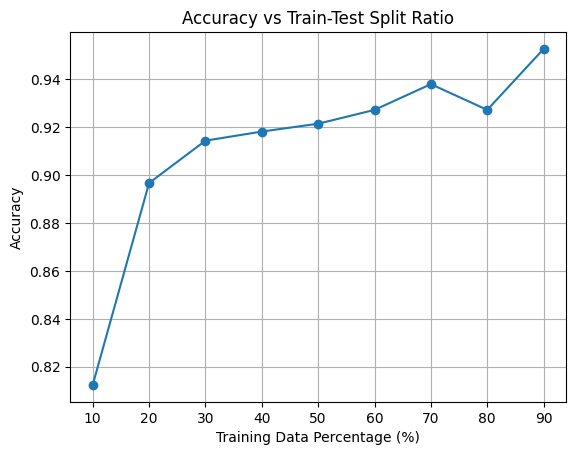

In [143]:
plt.plot([int(r*100) for r in ratios], accuracies, marker='o')
plt.title("Accuracy vs Train-Test Split Ratio")
plt.xlabel("Training Data Percentage (%)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [ ]:
# ----------------------------- Training ------------------------------------------------ #